In [2]:
from tqdm import tqdm
from dataset.cad_dataset import get_dataloader
from config import ConfigAE
from utils import ensure_dir
from trainer import TrainerAE
from trainer.loss import CADLoss
from trainer.accuracy import CADAccuracy
import torch
import numpy as np
import os
import h5py
#from cadlib.macro import EOS_IDX4

import torchvision.transforms as T
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import ast
from PIL import Image
from pathlib import Path
import os
import matplotlib.pyplot as plt

In [3]:
torch.cuda.empty_cache()

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

shuffled_df = pd.read_csv('data.csv')

shuffled_df.head()

n_datasample = len(shuffled_df)
print("Number of training samples:", n_datasample)


# Split Data
test_data = shuffled_df[:32*256].reset_index(drop=True)
val_data = shuffled_df[32*256:64*256].reset_index(drop=True)
train_data = shuffled_df[64*256:649*256].reset_index(drop=True)

Number of training samples: 166225


torch.Size([128, 1, 240, 240])


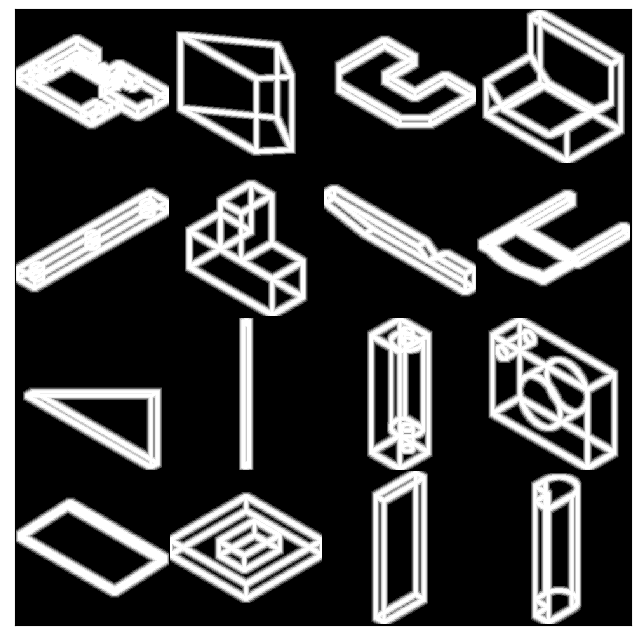

In [3]:
IMG_DIR = 'pics/'

# Get ground truth labels from DeepCAD outputa
class sketchDataset(Dataset):
    # Takes a pandas dataframe input of image filenames under 'Name' and labels under 'Rep'
    def __init__(self, df):
        self.X = df['Name']
        self.y = df['Rep']
        # transform normalizes and prepares image for pretraind VGG network (
        # norm µ and sigma from data used for VGG training)
        self.transform = T.Compose([
            T.Resize(256),
            T.CenterCrop(240),
            T.ToTensor(),
            T.Lambda(lambda tensor: ((-tensor + 1)>0).float()),
            # T.Normalize(mean=np.mean([0.485, 0.456, 0.406]), std=np.mean([0.229, 0.224, 0.225]))
        ])

    def __len__(self):
        # Denotes the total number of samples
        return len(self.X)

    def __getitem__(self, index):
        # Generates one sample of data
        imageFileName = self.X[index]
        label = ast.literal_eval(self.y[index])
        pad_token = [3] + 16 * [-1]
        label_pad = label + (60 - len(label)) * [pad_token]
        y_label = torch.tensor(label_pad)
        imageFileName = "".join(["0" for i in range(8-len(str(imageFileName)))]) + str(imageFileName)
        image = Image.open(IMG_DIR + imageFileName + '.png')
        image = image.convert('L')
        image = self.transform(image)

        def expand(array, a):
            # Define a kernel for convolution that checks for neighbors
            # Define a kernel for convolution that checks for neighbors
            kernel = torch.tensor([[1, 1, 1],
                                [1, 0, 1],
                                [1, 1, 1]], dtype=torch.float32)

            # Apply convolution to the input tensor
            convolved = torch.nn.functional.conv2d(array.unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0), padding=1)

            # Set positions with values greater than 0 to 1
            return ((convolved > 0).float()[0]-image)*a + image
        
        alpha = [0.7**j for j in range(6)]
        for i in range(len(alpha)):
            image = expand(image, alpha[i])
        return image, y_label[:, 0], y_label[:, 1:]

traindata = sketchDataset(train_data)
testdata = sketchDataset(test_data)
valdata = sketchDataset(val_data)

batch_size = 128
train_dataloader = DataLoader(traindata, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(testdata, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(valdata, batch_size, shuffle=True, num_workers=2, pin_memory=True)

def show_images(images, nmax=16):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=4).permute(1, 2, 0))

def show_batch(dl, nmax=16):
    for images in dl:
        show_images(images[0], nmax)
        print(images[0].shape)
        break

show_batch(train_dataloader)

In [4]:

class CNNEncoderVAE(nn.Module):
    def __init__(self, latent_dim):
        super(CNNEncoderVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder architecture
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(256, 512, kernel_size=7, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten()
        )

        # Linear layers for mean and log variance
        self.fc_mean = nn.Linear(8192, latent_dim)
        self.fc_logvar = nn.Linear(8192, latent_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        return mean + epsilon * std

    def forward(self, x):
        # Encoder forward pass
        features = self.encoder(x)
        batch_size = features.size(0)
        features = features.view(batch_size, -1)  # Flatten the features
        
        # Calculate mean and log variance
        mean = self.fc_mean(features)
        logvar = self.fc_logvar(features)
        
        # Reparameterize to sample from the latent space
        z = self.reparameterize(mean, logvar)
        

        return z, mean, logvar


class CNNDecoderVAE(nn.Module):
    def __init__(self, latent_dim):
        super(CNNDecoderVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Decoder architecture
        self.fc_mean = nn.Linear(latent_dim, 256)  # Linear layer for the mean
        self.fc_logvar = nn.Linear(latent_dim, 256)  # Linear layer for the log variance
        self.fc2 = nn.Linear(latent_dim, 8192)  # Reverse the dimensionality reduction from encoder
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.ConvTranspose2d(512, 256, kernel_size=7, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),  # Use sigmoid activation to constrain output between 0 and 1
        )

    def forward(self, z, mean, logvar):
        # Decode from the latent space z
    
        x = z.view(-1, 512, 4, 4)  # Reshape to match the last feature map size in the encoder
        x = self.decoder(x)
        return x, mean, logvar

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = CNNEncoderVAE(latent_dim)
        self.decoder = CNNDecoderVAE(latent_dim)

    def forward(self, x):
        # Encode input to obtain mean, logvar, and latent representation
        z, mean, logvar = self.encoder(x)
        
        # Decode from the latent representation
        reconstructed_x, _, _ = self.decoder(z, mean, logvar)
        
        return reconstructed_x, mean, logvar


In [ ]:
model = VAE(8192)
model.load_state_dict(torch.load("models/vae_sketch_19.pth"))

criterion = nn.BCELoss()
loss = 0
i = 0
model.eval()
with torch.no_grad():
    for images, labels_cmd, labels_param in val_dataloader:
        outputs = model(images)
        if i==0:
            fig, ax = plt.subplots(figsize=(8, 8))
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(make_grid((images.detach()[:16]), nrow=4).permute(1, 2, 0))
            fig2, ax2 = plt.subplots(figsize=(8, 8))
            ax2.set_xticks([])
            ax2.set_yticks([])
            ax2.imshow(make_grid((outputs[0].detach()[:16]), nrow=4).permute(1, 2, 0))
        loss += criterion(outputs[0], images)
        print(i)
        i+=1
print(loss)